In [99]:
from pathlib import Path
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader,Dataset,Subset
from torchvision import transforms
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This is a very basic neural network that serves as a baseline model. It consists of a single layer that flattens the RGB image and feeds it to a single output neuron for binary classification. The dataset is simple, containing images of apples and tomatoes, and the goal is to observe how well the network can distinguish between the two classes. This baseline will help track improvements as more complex non-linearities and network architectures are introduced.

In [100]:
DATA_ROOT = Path("/content/drive/MyDrive")
TRAIN_PATH = DATA_ROOT/"train"
APPLES_TRAIN_PATH = TRAIN_PATH/"apples"
TOMATOES_TRAIN_PATH = TRAIN_PATH/"tomatoes"

In [101]:
apples_images=list(APPLES_TRAIN_PATH.rglob("*.jpeg"))
print(f"The number of training apples are:{len(apples_images)}")

The number of training apples are:164


In [102]:
tomatoes_images=list(TOMATOES_TRAIN_PATH.rglob("*.jpeg"))
print(f"The number of training tomatoes are:{len(tomatoes_images)}")

The number of training tomatoes are:130


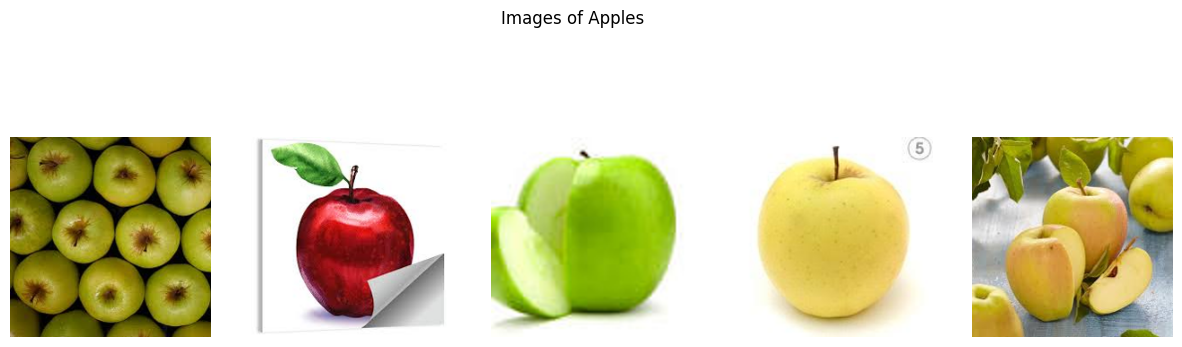

In [103]:
fig,axes=plt.subplots(1,5,figsize=(15,5))
for i in range(5):
  image=random.choice(apples_images)
  image=Image.open(image).resize((224,224))
  axes[i].imshow(image)
  axes[i].axis('off')
fig.suptitle("Images of Apples", x=0.5, y=0.95)
plt.show()

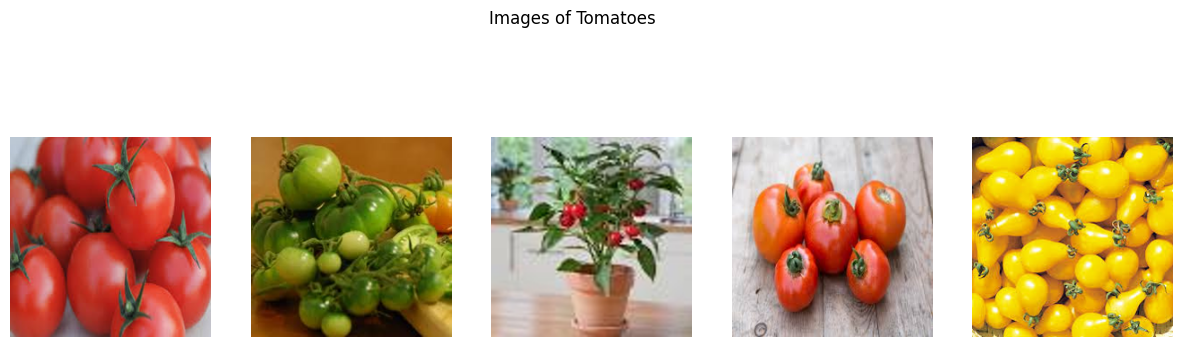

In [104]:
fig,axes=plt.subplots(1,5,figsize=(15,5))
for i in range(5):
  image=random.choice(tomatoes_images)
  image=Image.open(image).resize((224,224))
  axes[i].imshow(image)
  axes[i].axis('off')
fig.suptitle("Images of Tomatoes", x=0.5, y=0.95)
plt.show()

In [105]:
class CustomDataset(Dataset):

  def __init__(self,root_path,transforamtion=None):
    super().__init__()
    self.root_path=root_path
    self.transforamtion=transforamtion
    self.img_paths=[]
    self.labels=[]

    classes=["apples","tomatoes"]

    for index,class_name in enumerate(classes):
      class_folder=self.root_path/class_name
      for img in class_folder.iterdir():
        if img.is_file() and img.suffix.lower() in [".jpeg",".jpg",".png"]:
          self.img_paths.append(img)
          self.labels.append(index)

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, index):
    img=self.img_paths[index]
    label=self.labels[index]

    img=Image.open(img).convert("RGB").resize((224,224))

    if self.transforamtion:
      img=self.transforamtion(img)

    return img,label

In [106]:
class Model(nn.Module):

  def __init__(self,num_features,num_classes=2):
    super().__init__()
    self.classifier=nn.Flatten()
    self.linear=nn.Linear(num_features,num_classes)

  def forward(self,x):
    out=self.classifier(x)
    out=self.linear(out)
    return out

In [107]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])


In [108]:
dataset=CustomDataset(
    TRAIN_PATH,
    transforamtion=transform
)
print(len(dataset))

294


In [109]:
train_idx,val_idx=train_test_split(range(len(dataset)),test_size=0.2,random_state=True,stratify=dataset.labels)

In [110]:
train_data=Subset(dataset,train_idx)
val_data=Subset(dataset,val_idx)

In [111]:
train_dataloader=DataLoader(train_data,batch_size=8,shuffle=True)
val_dataloader=DataLoader(val_data,batch_size=8,shuffle=False)

In [112]:
model=Model(224*224*3)
loss=nn.CrossEntropyLoss()
learning_rate=1e-4
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
epochs=10

In [114]:
train_loss=[]
for epoch in range(epochs):
  epoch_loss=0
  for batch_feature,batch_label in train_dataloader:
    optimizer.zero_grad()
    output=model(batch_feature)
    loss_value=loss(output,batch_label)
    loss_value.backward()
    optimizer.step()
    epoch_loss += loss_value.item()
  avg_epoch_loss=epoch_loss/len(train_dataloader)
  train_loss.append(avg_epoch_loss)

  print(f"Epoch:{epoch+1}, Loss:{avg_epoch_loss:.4f}")

Epoch:1, Loss:0.0233
Epoch:2, Loss:0.1057
Epoch:3, Loss:0.2144
Epoch:4, Loss:0.1619
Epoch:5, Loss:0.0530
Epoch:6, Loss:0.0378
Epoch:7, Loss:0.0110
Epoch:8, Loss:0.0062
Epoch:9, Loss:0.0057
Epoch:10, Loss:0.0055


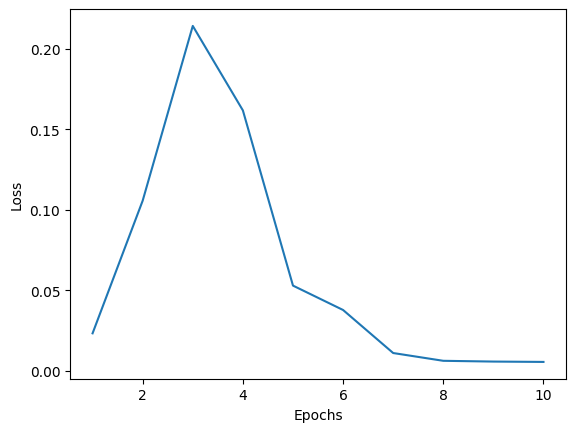

In [117]:
plt.plot(range(1,epochs+1),train_loss,label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()